In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve

from imblearn.pipeline import Pipeline
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# from xgboost import XGBClassifier

from metric_utils import get_model_metrics
from global_utils import get_globals

In [2]:
## Globals
DATA_PATH = get_globals().get('DATA_PATH')
COLORS = get_globals().get('COLORS')
RANDOM_STATE = get_globals().get('RANDOM_STATE')
TEST_SIZE = get_globals().get('TEST_SIZE')

# model params
MAX_DEPTH = get_globals().get('MAX_DEPTH')
ITER = get_globals().get('ITER')
N_JOBS = get_globals().get('N_JOBS')

# cross validation params
N_SPLITS = get_globals().get('N_SPLITS')
N_REPEATS = get_globals().get('N_REPEATS')
SCORING = get_globals().get('SCORING')

In [3]:
df = pd.read_csv(DATA_PATH)
X, y = df.drop(columns=['Class']), df['Class']
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# resampling strategies
ros = RandomOverSampler(random_state=RANDOM_STATE)
rus = RandomUnderSampler(random_state=RANDOM_STATE)
smote = SMOTE(sampling_strategy='auto', random_state=RANDOM_STATE, k_neighbors=5, n_jobs=N_JOBS)

# estimators
lrc = LogisticRegression(random_state=RANDOM_STATE, max_iter=ITER, n_jobs=N_JOBS)
rfc = RandomForestClassifier(max_depth=MAX_DEPTH, random_state=RANDOM_STATE)
# xgb = XGBClassifier(n_jobs=N_JOBS)

# cross validation strtategy
cv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_STATE)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [6]:
## Logistic Regression
pipe_ros_lrc = Pipeline([('resampling', ros), ('logistic', lrc)])
scores_ros_lrc = cross_validate(
    pipe_ros_lrc, X_train, y_train, scoring=SCORING, cv=cv, n_jobs=N_JOBS, return_train_score=True)
pipe_ros_lrc.fit(X_train, y_train)
y_pred_ros_lrc = pipe_ros_lrc.predict(X_test)
metrics_ros_lrc = get_model_metrics(y_test, y_pred_ros_lrc, 'ROS + LogReg', True)

pipe_rus_lrc = Pipeline([('resampling', rus), ('logistic', lrc)])
scores_rus_lrc = cross_validate(
    pipe_rus_lrc, X_train, y_train, scoring=SCORING, cv=cv, n_jobs=N_JOBS, return_train_score=True)
pipe_rus_lrc.fit(X_train, y_train)
y_pred_rus_lrc = pipe_rus_lrc.predict(X_test)
metrics_rus_lrc = get_model_metrics(y_test, y_pred_rus_lrc, 'RUS + LogReg', True)

pipe_smote_lrc = Pipeline([('resampling', smote), ('logistic', lrc)])
scores_smote_lrc = cross_validate(
    pipe_smote_lrc, X_train, y_train, scoring=SCORING, cv=cv, n_jobs=N_JOBS, return_train_score=True)
pipe_smote_lrc.fit(X_train, y_train)
y_pred_smote_lrc = pipe_smote_lrc.predict(X_test)
metrics_smote_lrc = get_model_metrics(y_test, y_pred_smote_lrc, 'SMOTE + LogReg', True)

scores_lrc = cross_validate(
    lrc, X_train, y_train, scoring=SCORING, cv=cv, n_jobs=N_JOBS, return_train_score=True)
lrc.fit(X_train, y_train)
y_pred_lrc = lrc.predict(X_test)
metrics_lrc = get_model_metrics(y_test, y_pred_lrc, 'LogReg', False)

In [7]:
## Random Forest Exp
pipe_ros_rfc = Pipeline([('resampling', ros), ('forest', rfc)])
scores_ros_rfc = cross_validate(
    pipe_ros_rfc, X_train, y_train, scoring=SCORING, cv=cv, n_jobs=N_JOBS, return_train_score=True)
pipe_ros_rfc.fit(X_train, y_train)
y_pred_ros_rfc = pipe_ros_lrc.predict(X_test)
metrics_ros_rfc = get_model_metrics(y_test, y_pred_ros_rfc, 'ROS + RanFor', True)

pipe_rus_rfc = Pipeline([('resampling', rus), ('forest', rfc)])
scores_rus_rfc = cross_validate(
    pipe_rus_rfc, X_train, y_train, scoring=SCORING, cv=cv, n_jobs=N_JOBS, return_train_score=True)
pipe_rus_rfc.fit(X_train, y_train)
y_pred_rus_rfc = pipe_rus_lrc.predict(X_test)
metrics_rus_rfc = get_model_metrics(y_test, y_pred_rus_rfc, 'RUS + RanFor', True)

pipe_smote_rfc = Pipeline([('resampling', smote), ('forest', rfc)])
scores_smote_rfc = cross_validate(
    pipe_smote_rfc, X_train, y_train, scoring=SCORING, cv=cv, n_jobs=N_JOBS, return_train_score=True)
pipe_smote_rfc.fit(X_train, y_train)
y_pred_smote_rfc = pipe_smote_lrc.predict(X_test)
metrics_smote_rfc = get_model_metrics(y_test, y_pred_smote_rfc, 'SMOTE + RanFor', True)

scores_rfc = cross_validate(
    rfc, X_train, y_train, scoring=SCORING, cv=cv, n_jobs=N_JOBS, return_train_score=True)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
metrics_rfc = get_model_metrics(y_test, y_pred_rfc, 'RanFor', False)

In [8]:
rename_map = {
    'test_f1': 'F-Score', 
    'test_recall': 'Recall', 
    'test_precision': 'Precision', 
    'test_roc_auc': 'ROC AUC',
    'test_geometric_mean_score': 'G-Mean'}

df_scores_lrc = pd.DataFrame(scores_lrc)  # .rename(columns=rename_map)
df_scores_ros_lrc = pd.DataFrame(scores_ros_lrc)  # .rename(columns=rename_map)
df_scores_rus_lrc = pd.DataFrame(scores_rus_lrc)  # .rename(columns=rename_map)
df_scores_smote_lrc = pd.DataFrame(scores_smote_lrc)  # .rename(columns=rename_map)

df_scores_rfc = pd.DataFrame(scores_rfc)  #.rename(columns=rename_map)
df_scores_ros_rfc = pd.DataFrame(scores_ros_rfc)  #.rename(columns=rename_map)
df_scores_rus_rfc = pd.DataFrame(scores_rus_rfc)  #.rename(columns=rename_map)
df_scores_smote_rfc = pd.DataFrame(scores_smote_rfc)  #.rename(columns=rename_map)


df_scores_lrc['exp_id'] = 'LogReg'
df_scores_ros_lrc['exp_id'] = 'ROS + LogReg'
df_scores_rus_lrc['exp_id'] = 'RUS + LogReg'
df_scores_smote_lrc['exp_id'] = 'SMOTE + LogReg'

df_scores_rfc['exp_id'] = 'RanFor'
df_scores_ros_rfc['exp_id'] = 'ROS + RanFor'
df_scores_rus_rfc['exp_id'] = 'RUS + RanFor'
df_scores_smote_rfc['exp_id'] = 'SMOTE + RanFor'

df_scores = pd.concat(
    [df_scores_lrc, df_scores_ros_lrc, df_scores_rus_lrc, df_scores_smote_lrc,
     df_scores_rfc, df_scores_ros_rfc, df_scores_rus_rfc, df_scores_smote_rfc], 
    ignore_index=True)

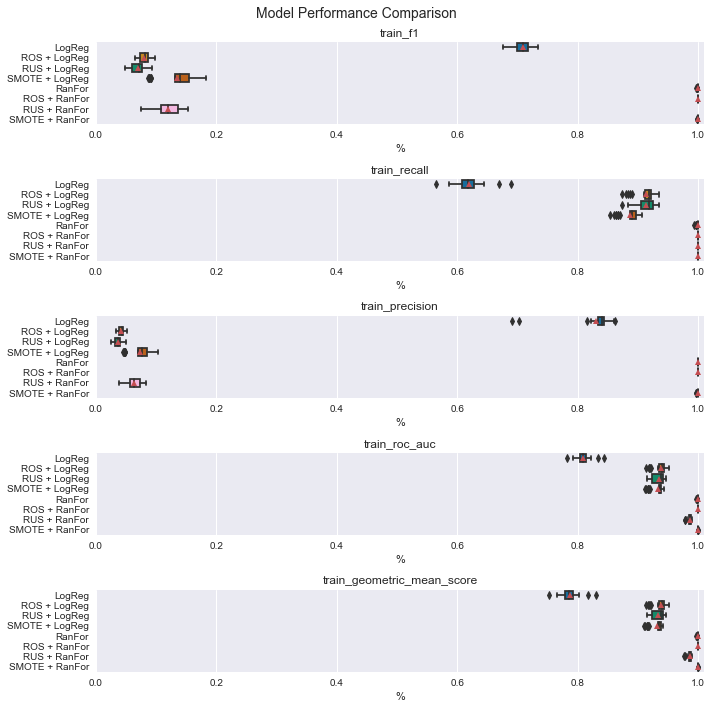

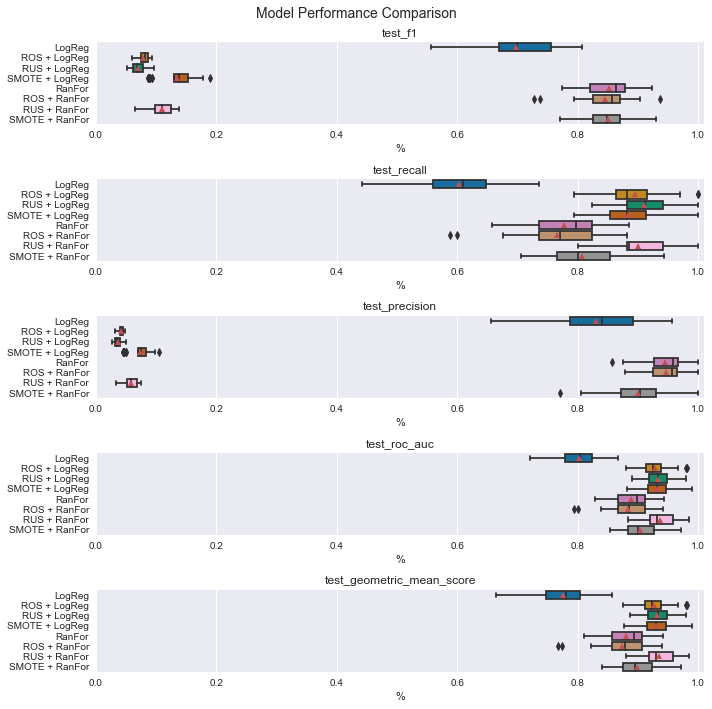

In [9]:
columns_to_plot = ['F-Score', 'Recall', 'Precision', 'ROC AUC', 'G-Mean']
train_metrics_list = [col for col in df_scores.columns if 'train' in col]
test_metrics_list = [col for col in df_scores.columns if 'test' in col]
columns_to_plot = [train_metrics_list, test_metrics_list]

for metric in columns_to_plot:
    _ = plt.figure(figsize=[10,10])
    plt.suptitle('Model Performance Comparison', fontsize=14)
    FMT = '%.3f%%'
    for i, col in enumerate(metric):
        plt.subplot(5, 1, i+1)
        ax = sns.boxplot(
            data=df_scores,
            x=col,
            y='exp_id',
            palette='colorblind',
            showmeans=True,
            orient='horizontal')
        ax.set_xlabel('%')
        plt.xlim([0,1.01])
        plt.ylabel(None)
        plt.title(col)

    plt.tight_layout()

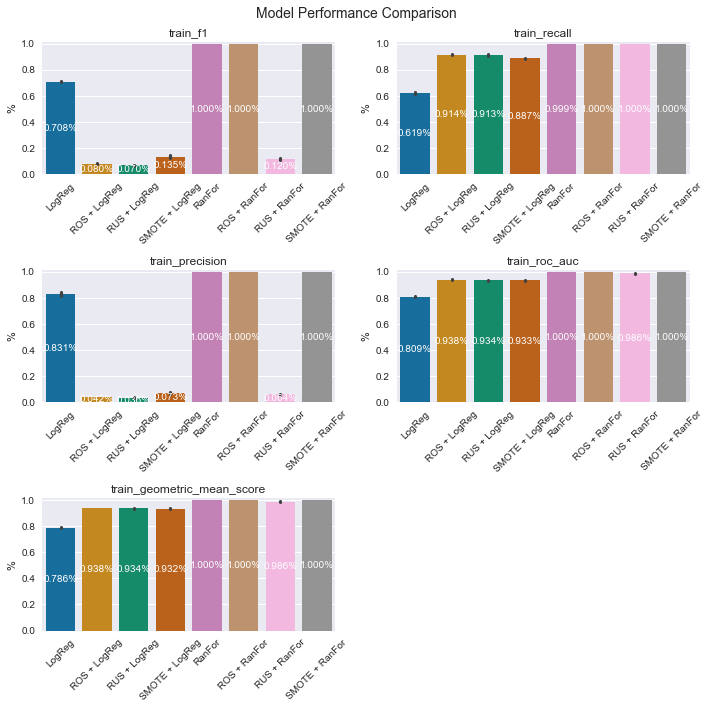

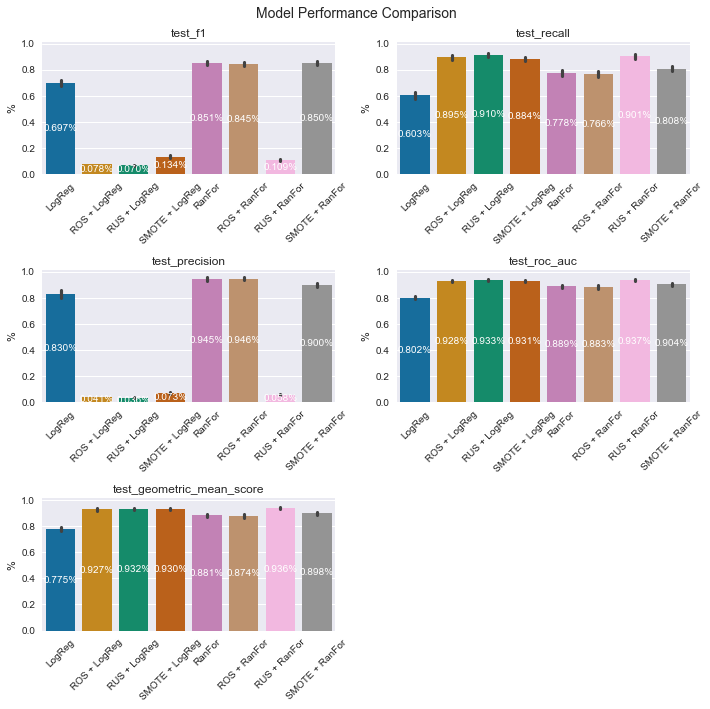

In [10]:
for metric in columns_to_plot:
    _ = plt.figure(figsize=[10,10])
    plt.suptitle('Model Performance Comparison', fontsize=14)
    FMT = '%.3f%%'
    for i, col in enumerate(metric):
        plt.subplot(3, 2, i+1)
        ax = sns.barplot(
            data=df_scores,
            x='exp_id',
            y=col,
            palette='colorblind')

        for container in ax.containers:
            ax.bar_label(container, label_type='center', color='white', fmt=FMT)

        ax.set_ylabel('%')
        plt.ylim([0,1.01])
        plt.xticks(rotation=45)
        plt.xlabel(None)
        plt.title(col)

    plt.tight_layout()

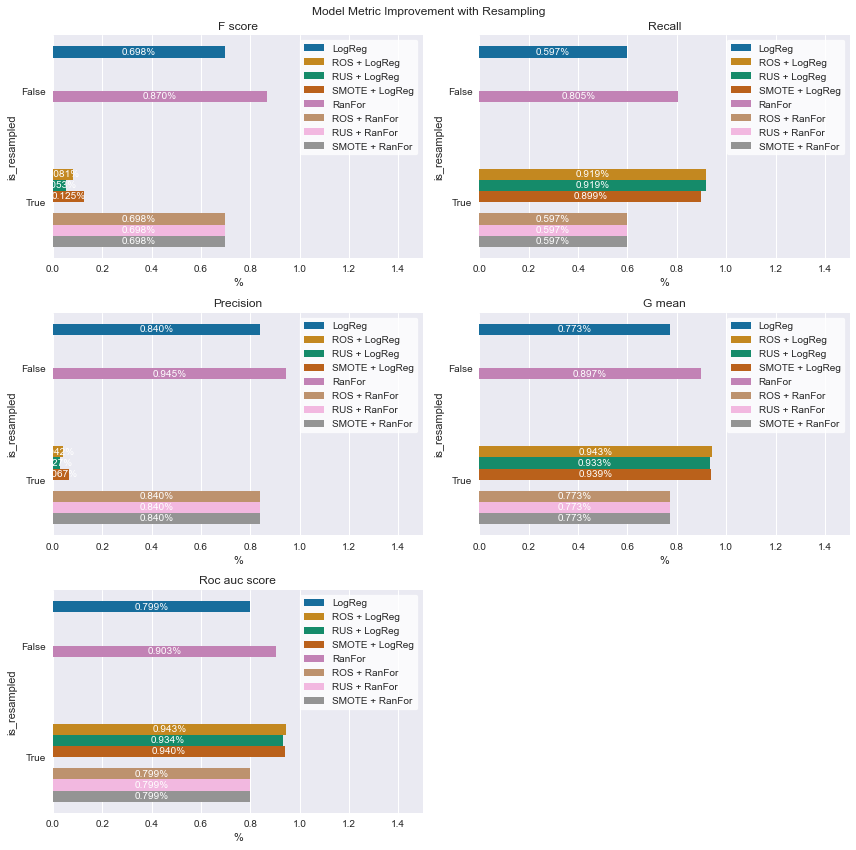

In [11]:
_ = plt.figure(figsize=[12,12])
plt.suptitle('Model Metric Improvement with Resampling')

df_model_metrics = pd.DataFrame(
    [metrics_lrc, metrics_ros_lrc, metrics_rus_lrc, metrics_smote_lrc, 
     metrics_rfc, metrics_ros_rfc, metrics_rus_rfc, metrics_smote_rfc])
metric_list = df_model_metrics.select_dtypes(include='float64').columns

for i, metric in enumerate(metric_list):
    plt.subplot(3, 2, i+1)
    ax = sns.barplot(
        data=df_model_metrics,
        x=metric,
        y='is_resampled',
        hue='exp_id',
        palette='colorblind',
        orient='h')
    for container in ax.containers:
        ax.bar_label(container, label_type='center', color='white', fmt=FMT)
    ax.set_xlabel('%')
    plt.xlim([0,1.5])
    plt.title(metric.replace('_', ' ').capitalize())
    legend = plt.legend(loc='upper right', frameon=True)
    frame = legend.get_frame()
    frame.set_color('white')
  
plt.tight_layout()

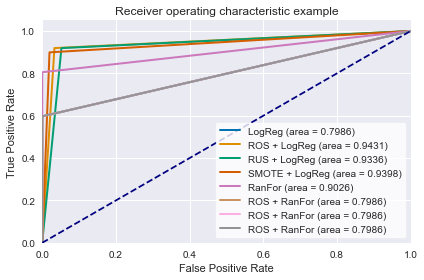

In [14]:
y_pred_list = [
    ('LogReg', y_pred_lrc), 
    ('ROS + LogReg', y_pred_ros_lrc), 
    ('RUS + LogReg', y_pred_rus_lrc),
    ('SMOTE + LogReg', y_pred_smote_lrc),
    ('RanFor', y_pred_rfc),
    ('ROS + RanFor', y_pred_ros_rfc),
    ('ROS + RanFor', y_pred_rus_rfc),
    ('ROS + RanFor', y_pred_smote_rfc)]

plt.figure()
for index, (exp_id, y_pred) in enumerate(y_pred_list):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    plt.plot(
        fpr,
        tpr,
        color=COLORS[index],  #"darkorange",
        lw=2,
        label="{0} (area = {1:.4f})".format(exp_id, roc_auc),
    )
    
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
legend = plt.legend(loc='lower right', frameon=True)
frame = legend.get_frame()
frame.set_color('white')
  

plt.tight_layout()